In [21]:
from utils.read_datasetBreakfast import load_data, read_mapping_dict
import os
import numpy as np


COMP_PATH = ''

''' 
training to load train set
test to load test set
'''
split = 'training'
#split = 'test'
train_split =  os.path.join(COMP_PATH, 'splits/train.split1.bundle') #Train Split
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'Data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

actions_dict = read_mapping_dict(mapping_loc)

data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels

Finish Load the Training data and labels!!!


In [26]:
segment_idx = []
with open("training_segment.txt") as f:
    while True:
        line = f.readline()
        if not line:
            break
        segment_idx.append(line[:-1].split(" "))
print(len(segment_idx))
print(len(data_feat))

1460
1460


In [14]:
import torch
new_data_feat = []
new_data_labels = []
frames_per_seg = 15
for i in range(0, len(data_feat)):
    total_frames, dim = data_feat[i].shape
    segment_num = int(total_frames / frames_per_seg)
    segments = data_feat[i][:segment_num * frames_per_seg].view(-1, frames_per_seg, 400)
    labels = torch.LongTensor([data_labels[i][:segment_num * frames_per_seg]]).view(-1, frames_per_seg)
    
    new_data_feat.append(segments)
    new_data_labels.append(labels)
    
new_data_feat = torch.cat(new_data_feat)
new_data_labels = torch.cat(new_data_labels)



In [18]:
from Dataset.VideoDataset import VideoDataset
import torch.utils.data as tud
from Models.LSTM import LSTM_Model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

epochs = 200
batch_size = 50

dataset = VideoDataset(new_data_feat, new_data_labels)
dataloader = tud.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LSTM_Model()
learning_rate = 1e-3
log_interval = 10000

def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    
    losses = []
    scores = []
    for batch_idx, (in_feature, label) in enumerate(train_loader):
        in_feature = in_feature.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(in_feature)
        output = output.view(-1, 48)
        label = label.flatten()
        loss = F.cross_entropy(output, label)
        losses.append(loss.item())
        
        label_predict = torch.max(output, 1)[1]
        step_score = accuracy_score(label.cpu().data.squeeze().numpy(), label_predict.cpu().data.squeeze().numpy())
        scores.append(step_score)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, (batch_idx+1)*batch_size, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
        
    return losses, scores

In [19]:
cuda_avail = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avail else "cpu")

lstm = LSTM_Model().double().to(device)
optimizer = torch.optim.Adam(list(lstm.parameters()), lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_train_scores = []
for epoch in range(epochs):
    train_losses, train_scores = train(log_interval, lstm, device, dataloader, optimizer, epoch)
    
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)

torch.save(model.state_dict(), "lstm.pt")
A = np.array(epoch_train_losses)
B = np.array(epoch_train_scores)
np.save('./training_losses_2.npy', A)
np.save('./training_scores_2.npy', B)
    

Train Epoch: 1 [50000/205006 (24%)]	Loss: 2.607353, Accu: 24.53%
Train Epoch: 1 [100000/205006 (49%)]	Loss: 2.469689, Accu: 28.27%
Train Epoch: 1 [150000/205006 (73%)]	Loss: 2.371619, Accu: 29.73%
Train Epoch: 1 [200000/205006 (98%)]	Loss: 2.103880, Accu: 38.67%
Train Epoch: 2 [50000/205006 (24%)]	Loss: 1.998282, Accu: 32.80%
Train Epoch: 2 [100000/205006 (49%)]	Loss: 2.442798, Accu: 33.20%
Train Epoch: 2 [150000/205006 (73%)]	Loss: 1.894272, Accu: 42.40%
Train Epoch: 2 [200000/205006 (98%)]	Loss: 2.204495, Accu: 34.53%
Train Epoch: 3 [50000/205006 (24%)]	Loss: 2.250979, Accu: 39.73%
Train Epoch: 3 [100000/205006 (49%)]	Loss: 2.151837, Accu: 43.87%
Train Epoch: 3 [150000/205006 (73%)]	Loss: 1.774406, Accu: 53.33%
Train Epoch: 3 [200000/205006 (98%)]	Loss: 1.957232, Accu: 42.53%
Train Epoch: 4 [50000/205006 (24%)]	Loss: 1.565540, Accu: 54.27%
Train Epoch: 4 [100000/205006 (49%)]	Loss: 1.538269, Accu: 56.27%
Train Epoch: 4 [150000/205006 (73%)]	Loss: 1.729088, Accu: 49.60%
Train Epoch: 4

RuntimeError: CUDA error: unspecified launch failure

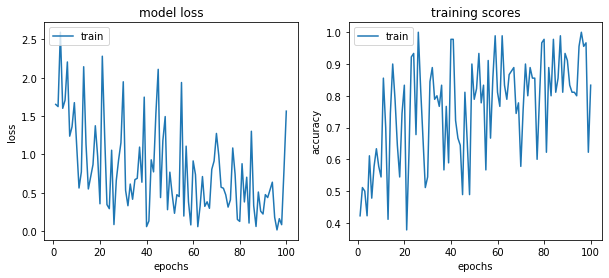

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train'], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train'], loc="upper left")
plt.show()
     

In [15]:
import numpy as np
A = np.load("training_losses_1.npy")
B = np.load("training_scores_1.npy")

print(A.shape)



(100, 10251)
